# Explicit differentiation for homogenization

In this example, we will test the differentiability of the framework for computational homogenization. Here, we use the most naive way of differentiating the entire numerical process of solving the RVE with respect to the macroscopic strain.

Ideally, we should use implicit differentiation to differentiate through the Newton-Raphson iterations, but this is a good starting point.

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp
import numpy as np

In [ ]:
from functools import partial
from typing import Callable

import matplotlib.pyplot as plt
from skimage.morphology import disk
from spectralsolver import (
    DifferentialMode,
    SpectralSpace,
    TensorOperator,
    make_field,
)
from spectralsolver.operators import fourier_galerkin

In this example, we will test the code for computational homogenization. To this end, we will consider a simple RVE with an inclusion of volume fraction = `0.7 %`. This example is taken from  Gokuzum and Kiep, Wicht et. al (2020) 

[Link](https://onlinelibrary.wiley.com/doi/10.1002/nme.6579)

## constructing an RVE with an inclusion

- inclusion = 1
- solid = 0


We construct the RVE with an volume fraction of 0.7 %

In [ ]:
volume_fraction_percentage = 0.007

In [4]:
length = 0.1
H, L = (255, 255)

dx = length / H
dy = length / L

Hmid = int(H / 2)
Lmid = int(L / 2)
vol_inclusion = volume_fraction_percentage * (length * length)
r = (
    int(np.sqrt(vol_inclusion / np.pi) / dx) + 1
)  # Since the rounding off leads to smaller fraction therefore we add 1.

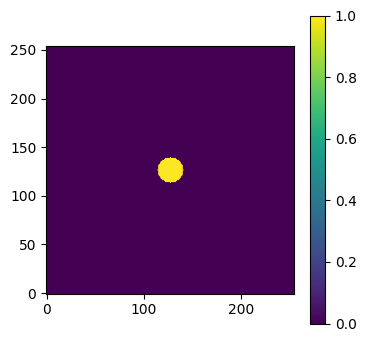

In [ ]:
structure = np.zeros((H, L))
structure[Hmid - r : Hmid + 1 + r, Lmid - r : Lmid + 1 + r] += disk(r)

plt.figure(figsize=(4, 4))
cb = plt.imshow(structure, origin="lower")
plt.colorbar(cb)
plt.show()

In [ ]:
ndim = len(structure.shape)
N = structure.shape[0]

## material parameters

In [ ]:
# material parameters + function to convert to grid of scalars
def param(X, inclusion, solid):
    return inclusion * jnp.ones_like(X) * (X) + solid * jnp.ones_like(X) * (1 - X)

In [ ]:
# material parameters
# lames constant
lambda_modulus = {"solid": 2.0, "inclusion": 10}
shear_modulus = {"solid": 1.0, "inclusion": 5}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = (
    lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3
)

In [9]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

## linear elastic constituive relation

Now, we define the stress-strain relationship, for this we directly derive the `stress` function by autodifferentiating the `strain energy` expression.

$$
\psi = \dfrac{1}{2}(\text{tr}(\varepsilon_{ii})^2 + \mu \text{tr}(\varepsilon_{ij}\varepsilon_{jk} )$$

$$
\sigma_{ij} = \dfrac{\partial \psi}{\partial \varepsilon_{ij}}
$$

For FFT scheme, we define the above strain expression for each grid point ($x,y$)

$$
\psi_{xy} = \dfrac{1}{2}(\text{tr}(\varepsilon_{iixy})^2 + \mu \text{tr}(\varepsilon_{ijxy}\varepsilon_{jkxy} ) 
$$

$$
\sigma_{ijxy} = \dfrac{\partial \psi_{xy}}{\partial \varepsilon_{ijxy}}
$$


In [10]:
tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)

In [16]:
@jax.jit
def strain_energy(eps):
    eps_sym = 0.5 * (eps + tensor.trans(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace(tensor.dot(eps_sym, eps_sym))
    )
    return energy.sum()


compute_stress = jax.jit(jax.jacrev(strain_energy))

In [17]:
Ghat = fourier_galerkin.compute_projection_operator(
    space=space, diff_mode=DifferentialMode.rotated_difference
)

In [19]:
def _tangent(deps, Ghat, dofs_shape):
    deps = deps.reshape(dofs_shape)
    dsigma = compute_stress(deps)
    return jnp.real(space.ifft(tensor.ddot(Ghat, space.fft(dsigma)))).reshape(-1)


def _residual(deps, Ghat, dofs_shape):
    deps = deps.reshape(dofs_shape)
    sigma = compute_stress(deps)
    return jnp.real(space.ifft(tensor.ddot(Ghat, space.fft(sigma)))).reshape(-1)


residual = jax.jit(partial(_residual, Ghat=Ghat, dofs_shape=eps.shape))
jacobian = jax.jit(partial(_tangent, Ghat=Ghat, dofs_shape=eps.shape))

In [20]:
from spectralsolver.solvers.nonlinear import (
    conjugate_gradient_while,
    newton_krylov_solver,
)

Now we define a python function that takes the macro strain as an input and return the macro stress. Inside the function, we solve the RVE problem for the given macro strain and return the averaged local stresses as the macro stress.

Later, we use the `jax.jacfwd` to automatically differentiate this function to get the tangent modulus.

In [ ]:
@jax.jit
def local_constitutive_update(macro_strain):
    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    eps = jnp.array(make_field(dim=2, N=N, rank=2))
    # set macroscopic loading
    DE = jnp.zeros(eps.shape)
    DE = DE.at[0, 0].set(macro_strain[0])
    DE = DE.at[1, 1].set(macro_strain[1])
    DE = DE.at[0, 1].set(macro_strain[2] / 2.0)
    DE = DE.at[1, 0].set(macro_strain[2] / 2.0)

    # initial residual: distribute "DE" over grid using "K4"
    b = -residual(DE)
    eps = jax.lax.add(eps, DE)
    En = jnp.linalg.norm(eps)

    final_state = newton_krylov_solver(
        state=(DE, b, eps),
        gradient=residual,
        jacobian=jacobian,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )

    DE, b, eps = final_state
    sig = compute_stress(eps)

    # get the macro stress
    macro_sigma = jnp.array(
        [
            jnp.sum(sig.at[0, 0].get() * dx * dy),
            jnp.sum(sig.at[1, 1].get() * dx * dy),
            0.5
            * (
                jnp.sum(sig.at[1, 0].get() * dx * dy)
                + jnp.sum(sig.at[0, 1].get() * dx * dy)
            ),
        ]
    )
    macro_sigma = macro_sigma / length**2

    return macro_sigma, (macro_sigma, sig, eps)

In [ ]:
tangent_operator_and_state = jax.jit(
    jax.jacfwd(local_constitutive_update, argnums=0, has_aux=True)
)

In [ ]:
deps = jnp.array([1.2, 1.0, 1])
tangent, state = tangent_operator_and_state(deps)

Converged, Residual value : 7.483524123499033e-09


In [31]:
tangent

Array([[ 4.03424410e+00,  2.01513204e+00,  1.38675881e-13],
       [ 2.01513204e+00,  4.03424410e+00, -2.80291756e-13],
       [ 5.45208231e-13, -1.06043378e-13,  1.00930553e+00]],      dtype=float64)

The solution matches the Eshelby's analytical solution. Not exactly, but same result is also obtained by Gokuzum and Kiep. 